<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone

# Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Models and metrics
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_pinball_loss, make_scorer
from sklearn.model_selection import ParameterGrid

### Load Data

In [2]:
# Load the processed datasets (train, validation, test)
X_train = pd.read_parquet("./project_data/X_train_final.parquet", engine="pyarrow")
X_val   = pd.read_parquet("./project_data/X_val_final.parquet",   engine="pyarrow")
X_test  = pd.read_parquet("./project_data/X_test_final.parquet",  engine="pyarrow")

y_train_df = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val_df   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set 'carID' as the index for all sets
X_train.set_index('carID', inplace=True)
X_val.set_index('carID', inplace=True)
X_test.set_index('carID', inplace=True)

# Extract the target variable 'price' as a Series and ensure its index is 'carID'
y_train = y_train_df.set_index('carID')['price']
y_val = y_val_df.set_index('carID')['price']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (59088, 38)
Shape of y_train: (59088,)
Shape of X_val: (15193, 38)
Shape of y_val: (15193,)
Shape of X_test: (32567, 38)


In [3]:
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

In [4]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'mpg_is_missing', 'tax_is_missing',
       'engineSize_is_missing', 'year_is_missing', 'brand_mean_price',
       'brand_median_price', 'brand_price_std', 'brand_count', 'age',
       'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage',
       'low_mileage', 'age_mileage_interaction',
       'premium_brand_engine_size_interaction', 'tax_per_engine',
       'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
       'transmission_manual', 'transmission_other', 'transmission_semi auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
       'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

<div style="background-color:#644712c5; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2.11 | Feature Selection</b></span>
    </h1>
</div>

In [5]:
#Utils
#Plots the error curve (MAE) for Train and Validation in Wrapper methods (RFE/SFS)
def plot_rfe_sfs_scores(train_scores, val_scores, optimal_n, model_name, method_name):
    nof_list = np.arange(1, len(train_scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(nof_list, train_scores, label=f"MAE Train ({model_name})", color=palette[4])
    plt.plot(nof_list, val_scores, label=f"MAE Validation ({model_name})", color=palette[0])
    
    # Add vertical line at optimal point
    plt.axvline(x=optimal_n, color='red', linestyle='--', label=f'Optimal (n={optimal_n})')
    
    plt.xlabel("NNumber of Features")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.title(f"{method_name} - Optimization of MAE vs. Number of Features ({model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
#Utils
#Plots feature importance for embedding methods (top 20)
def plot_importance_unified(importance_series, name, is_tree_model=False):
    # Select the top 20 most important features
    imp_coef = importance_series.sort_values(ascending=False).head(20)
    
    color = palette[1] if is_tree_model else palette[0]
    plt.figure(figsize=(9, 6))
    imp_coef.sort_values().plot(kind="barh", color=color) 
    
    plt.title("Feature Importance using " + name + " Model (Top 20)", fontsize=15)
    plt.xlabel("Magnitude of Coefficient / Gini Importance")
    plt.show()

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.1 |  Filter Methods</b></span>
    </h1>
</div>

##### **Variance Threshold**

In [7]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train)

# Get low variance columns and print them
low_variance = X_train.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train.columns.get_loc(col)]:.4f}")

Number of features with variance closer to zero: 1
Features with variance closer to zero:
hasDamage: 0.0000


In [8]:
# Drop low variance columns from train, val and test sets
for d in [X_train, X_val , X_test]:
    d = d.drop(columns=low_variance, errors='ignore', inplace=True)

In [9]:
###APAGAR: Pode ser preciso adaptar se juntarmos mais alguma variável p.e. (hasDamage, transmission_other, fuelType_other, fuelType_electric)
bin_variables = list(X_train.columns[X_train.nunique() == 2])

categorical_variables = ['Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_semi auto', 
                         'transmission_unknown','fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown'] 

ordinal_variables = ['brand_segment_luxury', 'brand_segment_mid_range']

numerical_variables = [
    col for col in X_train.columns 
    if col not in (bin_variables + categorical_variables + ordinal_variables)
]

##### **Correlation Indices**

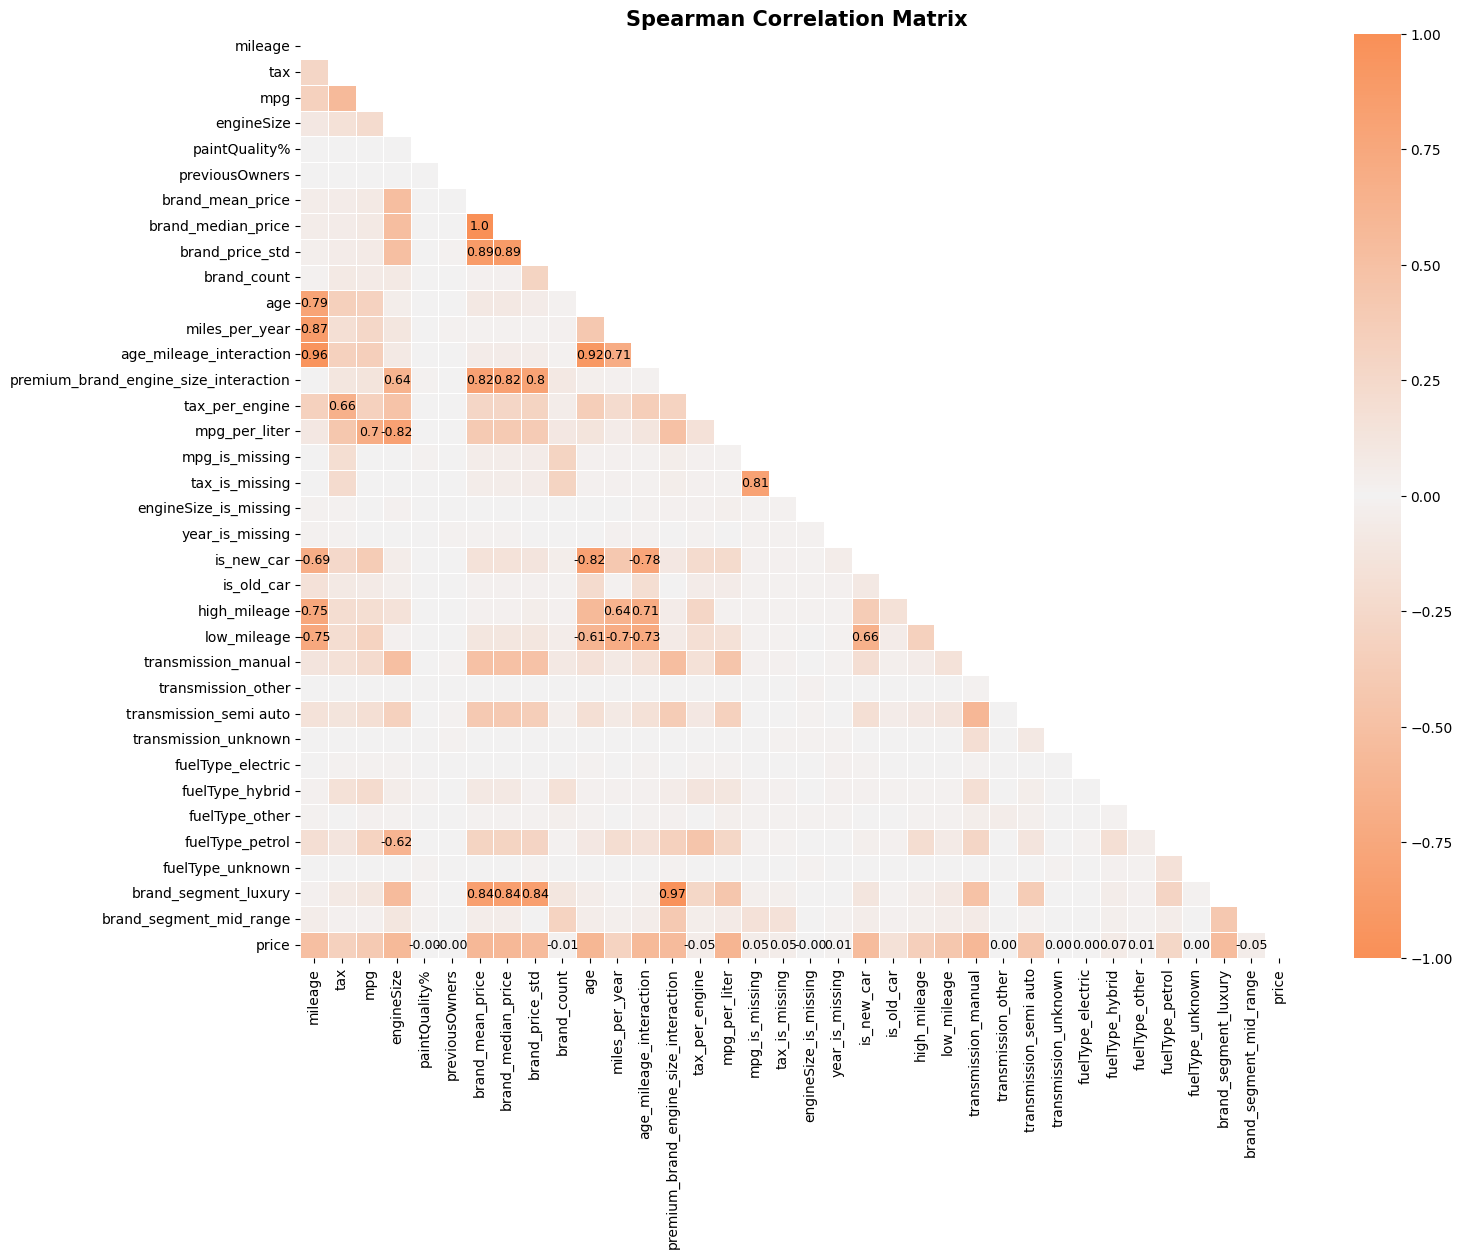

In [10]:
# Create a filtered DataFrame with only numeric and binary columns
X_train_filtered = X_train[numerical_variables+bin_variables].copy()

##### Spearman Correlation ####
cor = pd.concat([X_train_filtered, y_train], axis=1).corr(method='spearman').round(2)

TARGET_COL = 'price'
price_index = cor.columns.get_loc(TARGET_COL)

# Create custom annotation matrix for weak correlations
annot_matrix = np.full(cor.shape, "", dtype=object)
for i, col in enumerate(cor.index):
    corr_value = cor.loc[col, TARGET_COL]
    # Annotate only if |corr| < 0.1
    if abs(corr_value) < 0.1 and i != price_index:
        annot_matrix[price_index, i] = f"{corr_value:.2f}"
        
# Create main annotation matrix for strong correlations
# Annotate only if |corr| >= 0.6
mask_annot_main = np.absolute(cor.values) >= 0.6
# Exclude 'price' row and column from this matrix
mask_annot_main[:, price_index] = False
mask_annot_main[price_index, :] = False
annot_main = np.where(mask_annot_main, cor.values.astype(str), "")

# Create the final annotation matrix by combining the two logics
final_annot_matrix = annot_main.copy()
for i in range(cor.shape[0]):
    for j in range(cor.shape[1]):
        # If the main annotation is empty and the weak one has a value, use the weak value
        if final_annot_matrix[i, j] == "" and annot_matrix[i, j] != "":
            final_annot_matrix[i, j] = annot_matrix[i, j]

# Plotting
plt.figure(figsize=(16, 12))

# Create a custom diverging colormap based on orange tones
cmap = sns.diverging_palette(h_neg=30, h_pos=30, s=90, l=70, n=256, center="light", as_cmap=True) 

# Create a Mask to hide the upper triangle (to avoid redundancy)
mask = np.zeros_like(cor, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    data=cor,
    mask=mask,
    cmap=cmap,
    annot=final_annot_matrix, # combined annotation matrix
    fmt='s',                  # Format annotations as strings
    vmin=-1, vmax=1, center=0,# Ensure the scale is from -1 to 1, centered at 0
    linewidths=0.5,
    annot_kws={"fontsize": 9, "color": "black"},
)

plt.title('Spearman Correlation Matrix', fontsize=15, fontweight='bold')
plt.show()

##### **Statistical Hypothesis Testing** 

We performed this Chi-squared test in Part 1 of the notebook, and the results are shown here:<br>

The variables 'Brand' and 'model' are NOT independent (they are REDUNDANT)      
The variables 'Brand' and 'transmission' are NOT independent (they are REDUNDANT)     
The variables 'Brand' and 'fuelType' are NOT independent (they are REDUNDANT)     
The variables 'Brand' and 'brand_model' are NOT independent (they are REDUNDANT)      
The variables 'Brand' and 'hasDamage' are INDEPENDENT (they are NOT redundant)      
The variables 'model' and 'transmission' are NOT independent (they are REDUNDANT)      
The variables 'model' and 'fuelType' are NOT independent (they are REDUNDANT)         
The variables 'model' and 'brand_model' are NOT independent (they are REDUNDANT)       
The variables 'model' and 'hasDamage' are INDEPENDENT (they are NOT redundant)       
The variables 'transmission' and 'fuelType' are NOT independent (they are REDUNDANT)     
The variables 'transmission' and 'brand_model' are NOT independent (they are REDUNDANT)     
The variables 'transmission' and 'hasDamage' are INDEPENDENT (they are NOT redundant)     
The variables 'fuelType' and 'brand_model' are NOT independent (they are REDUNDANT)    
The variables 'fuelType' and 'hasDamage' are INDEPENDENT (they are NOT redundant)     
The variables 'brand_model' and 'hasDamage' are INDEPENDENT (they are NOT redundant)  <BR><BR><BR>

For all the remaining variables (note that *hasDamage* has already been discarded), they are redundant with each other. We decided **not to consider this test**, as it would result in keeping only a single categorical variable, potentially leading to the **loss of relevant information**.

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.2 |  Wrapper Methods</b></span>
    </h1>
</div>

##### **RFE**

We applied **RFE (Recursive Feature Elimination)** based on the class example but extended it to work with both **Linear Regression** and **Random Forest** models, using **MAE** as the optimization criterion. The procedure iteratively removes the least important features, retraining the model each time to identify the subset of features that minimizes validation error. This approach allows us to balance model simplicity and predictive performance, ensuring that only the most relevant predictors are retained.


In [11]:
def plot_rfe_scores(train_scores, val_scores, optimal_n, model_name):
    nof_list = np.arange(1, len(train_scores) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(nof_list, train_scores, label=f"MAE Train ({model_name})", color=palette[4])
    plt.plot(nof_list, val_scores, label=f"MAE Validation ({model_name})", color=palette[0])
    
    #vertical line at the optimal point
    plt.axvline(x=optimal_n, color='red', linestyle='--', label=f'Optimal (n={optimal_n})')
    
    plt.xlabel("Number of Features")
    plt.ylabel("MAE (Mean Absolute Error)")
    plt.title(f"RFE - Optimization of Number of Features ({model_name})")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [12]:
def find_optimal_features_rfe(model, X_train, y_train, X_val, y_val):
    nof_list = np.arange(1, len(X_train.columns) + 1)
    low_score = float('inf')  # Start with an infinite value to find the minimum
    nof = 0
    train_score_list = []
    val_score_list = []

    print(f"Running RFE with model: {model.__class__.__name__}")

    for n in nof_list:
        # Use clone to ensure the model is "clean" in each iteration
        estimator = clone(model)
        
        rfe = RFE(estimator=estimator, n_features_to_select=n)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_val_rfe = rfe.transform(X_val)

        # Train the final model with the selected features
        estimator.fit(X_train_rfe, y_train)
        
        # Store the MAE scores
        train_pred = estimator.predict(X_train_rfe)
        train_mae = mean_absolute_error(y_train, train_pred)
        train_score_list.append(train_mae)
        
        val_pred = estimator.predict(X_val_rfe)
        val_mae = mean_absolute_error(y_val, val_pred)
        val_score_list.append(val_mae)

        # Check for the lowest validation error
        if val_mae <= low_score:
            low_score = val_mae
            nof = n

    print(f"Optimal number of features: {nof} with a validation MAE of {low_score:.4f}")

    # Train the final model with the optimal number of features to get the final feature list
    final_rfe = RFE(estimator=clone(model), n_features_to_select=nof)
    final_rfe.fit(X_train, y_train)
    selected_features_names = X_train.columns[final_rfe.support_].tolist()

    # Return all useful results
    return {
        'optimal_n': nof,
        'best_score': low_score,
        'selected_features': selected_features_names,
        'train_scores': train_score_list,
        'val_scores': val_score_list
    }

Running RFE with model: LinearRegression
Optimal number of features: 27 with a validation MAE of 2587.5011
LR Features (27): ['mileage', 'tax', 'mpg', 'engineSize', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'miles_per_year', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']



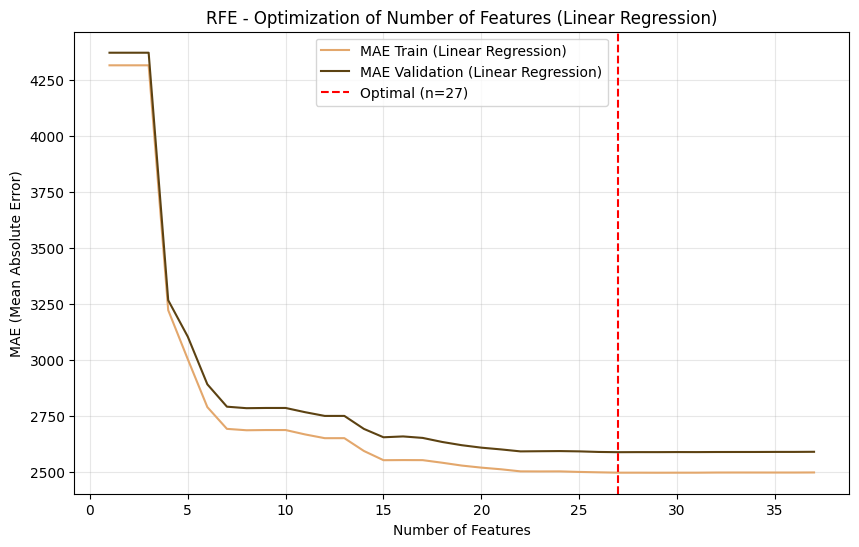

Running RFE with model: RandomForestRegressor
Optimal number of features: 37 with a validation MAE of 1359.4003
RF Features (37): ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_other', 'transmission_semi auto', 'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']


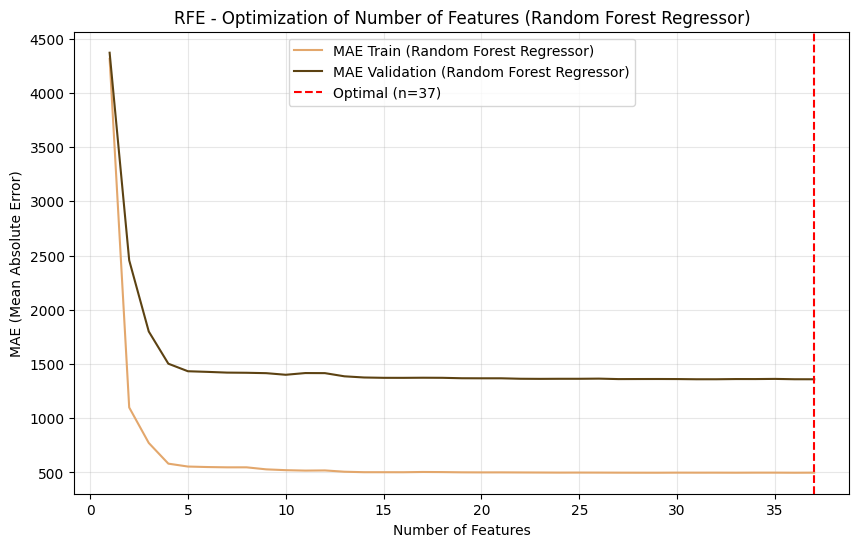

In [13]:
# RFE with Linear Regression optimized for MAE
lr_model = LinearRegression()
rfe_results_lr = find_optimal_features_rfe(lr_model, X_train, y_train, X_val, y_val)
print(f"LR Features ({rfe_results_lr['optimal_n']}): {rfe_results_lr['selected_features']}\n")
plot_rfe_scores(rfe_results_lr['train_scores'], rfe_results_lr['val_scores'], rfe_results_lr['optimal_n'], 'Linear Regression')

# RFE com RandomForest Regressor optimized for MAE
rf_model = RandomForestRegressor(n_estimators=50, random_state=37, n_jobs=-1)
rfe_results_rf = find_optimal_features_rfe(rf_model, X_train, y_train, X_val, y_val)
print(f"RF Features ({rfe_results_rf['optimal_n']}): {rfe_results_rf['selected_features']}")
plot_rfe_scores(rfe_results_rf['train_scores'], rfe_results_rf['val_scores'], rfe_results_rf['optimal_n'], 'Random Forest Regressor')

<div style="background-color: #e5c120ff; padding:15px; border-radius:10px;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(255, 255, 255, 1);"><b>2.11.3 |  Embedded Methods</b></span>
    </h1>
</div>


INÍCIO: EMBEDDING METHODS (LASSO, RIDGE, TREES)


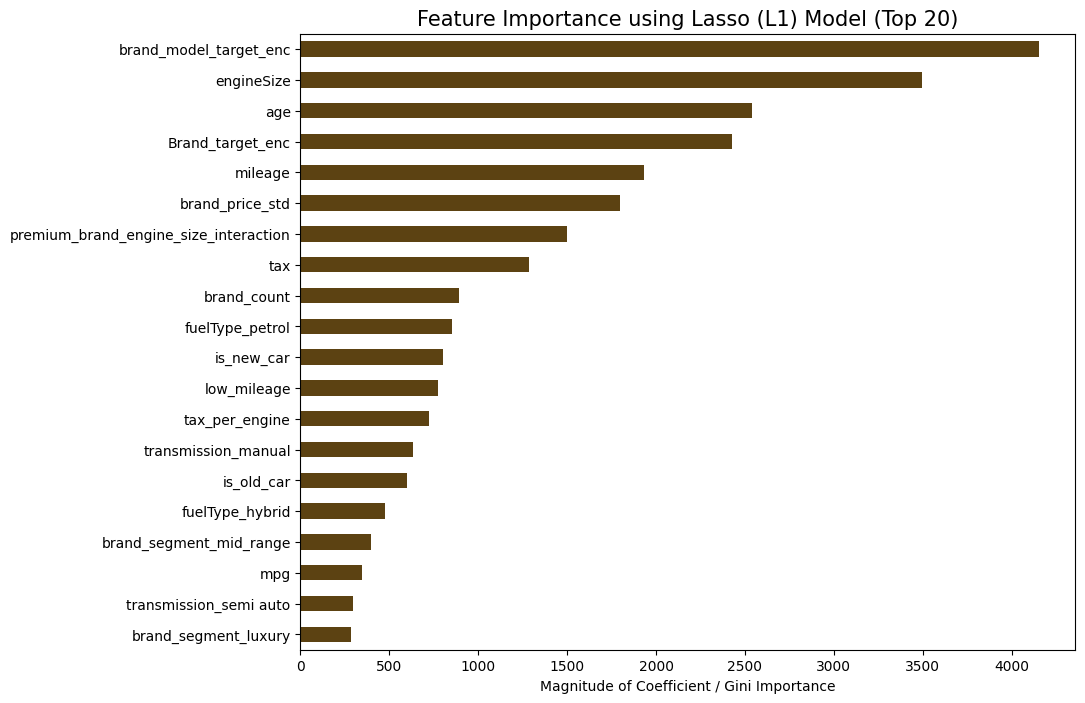


------------------------------------------------------------
MODEL: Lasso (L1)
Selection Criteria: Coefficient != 0
Number of features selected: 36
Selected Features: ['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'mpg_is_missing', 'tax_is_missing', 'engineSize_is_missing', 'year_is_missing', 'brand_mean_price', 'brand_price_std', 'brand_count', 'age', 'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage', 'low_mileage', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc', 'transmission_manual', 'transmission_other', 'transmission_semi auto', 'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_other', 'fuelType_petrol', 'fuelType_unknown', 'brand_segment_luxury', 'brand_segment_mid_range']
------------------------------------------------------------



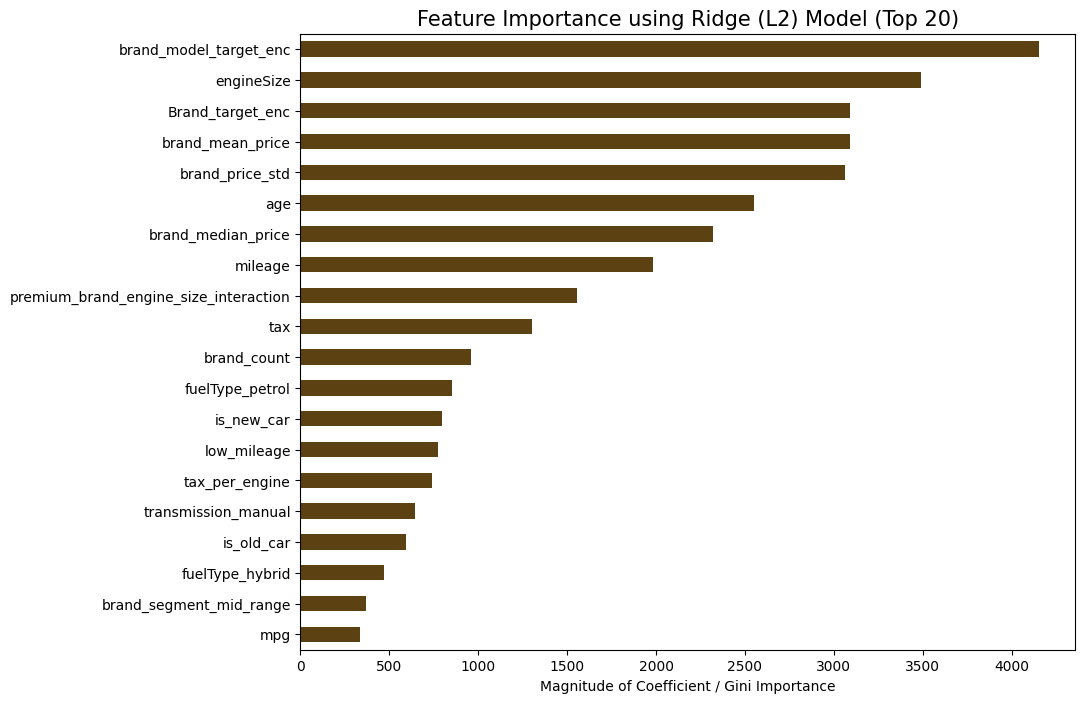


------------------------------------------------------------
MODEL: Ridge (L2)
Selection Criteria: Importance > Mean (939.8644)
Number of features selected: 11
Selected Features: ['mileage', 'tax', 'engineSize', 'brand_mean_price', 'brand_median_price', 'brand_price_std', 'brand_count', 'age', 'premium_brand_engine_size_interaction', 'Brand_target_enc', 'brand_model_target_enc']
------------------------------------------------------------



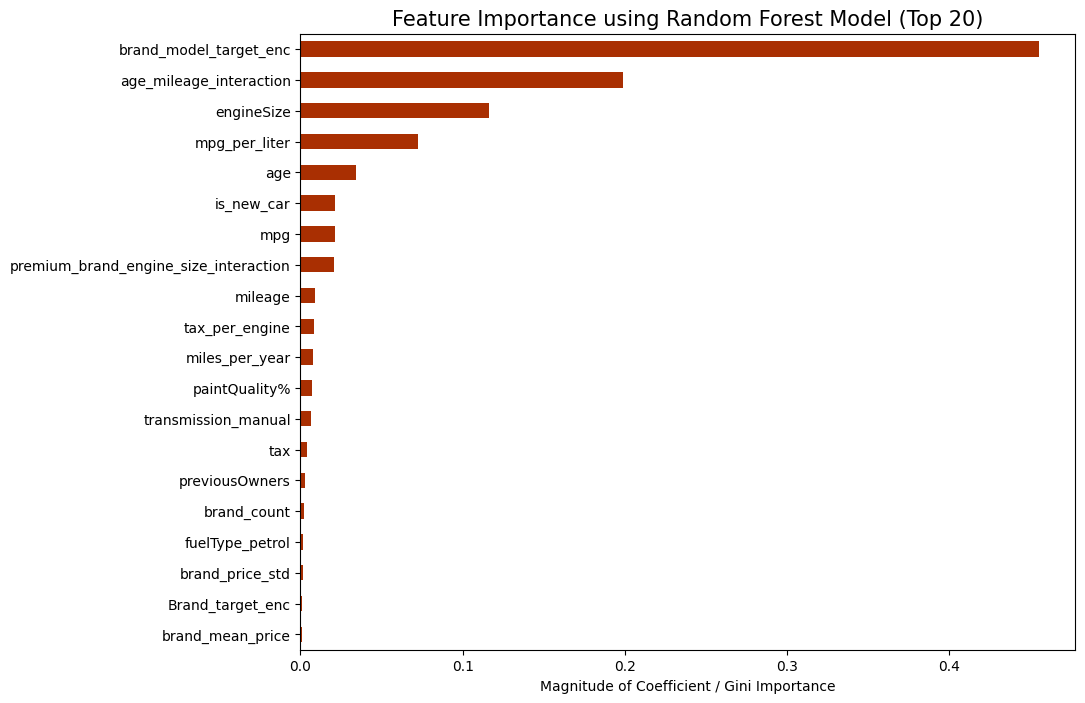


------------------------------------------------------------
MODEL: Random Forest
Selection Criteria: Importance > Mean (0.0270)
Number of features selected: 5
Selected Features: ['engineSize', 'age', 'age_mileage_interaction', 'mpg_per_liter', 'brand_model_target_enc']
------------------------------------------------------------



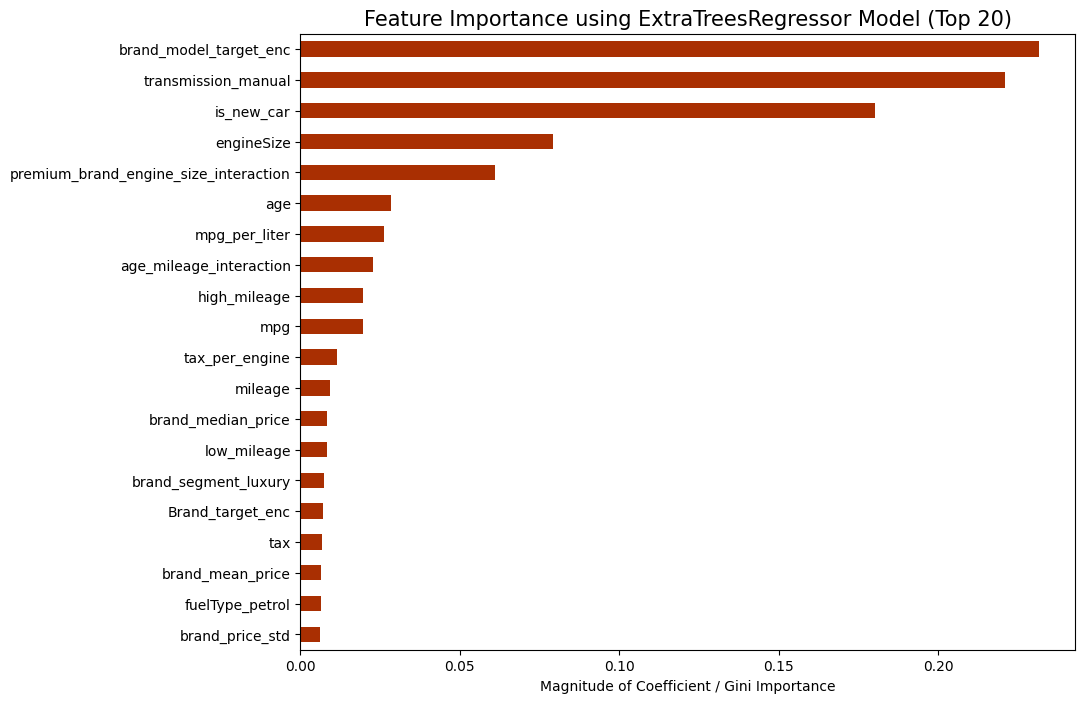


------------------------------------------------------------
MODEL: ExtraTreesRegressor
Selection Criteria: Importance > Mean (0.0270)
Number of features selected: 6
Selected Features: ['engineSize', 'age', 'is_new_car', 'premium_brand_engine_size_interaction', 'brand_model_target_enc', 'transmission_manual']
------------------------------------------------------------



In [ ]:
from sklearn.feature_selection import SelectFromModel

# Função auxiliar para imprimir e selecionar (evita repetição)
def print_selection_results(importance_series, model_name, selection_method="nonzero"):
    """
    selection_method: 
      - 'nonzero': Para Lasso (seleciona tudo o que não é 0)
      - 'mean': Para Ridge/Trees (seleciona tudo acima da média de importância)
    """
    if selection_method == "nonzero":
        # Para Lasso: seleciona se diferente de zero
        selected_feats = importance_series[importance_series != 0].index.tolist()
        criteria_msg = "Coefficient != 0"
    else:
        # Para Ridge e Árvores: seleciona se acima da média
        threshold = importance_series.mean()
        selected_feats = importance_series[importance_series > threshold].index.tolist()
        criteria_msg = f"Importance > Mean ({threshold:.4f})"

    print(f"\n" + "-"*60)
    print(f"MODEL: {model_name}")
    print(f"Selection Criteria: {criteria_msg}")
    print(f"Number of features selected: {len(selected_feats)}")
    print(f"Selected Features: {selected_feats}")
    print("-"*60 + "\n")


In [ ]:
# --- Lasso Regularization (L1) ---
# O Lasso zera coeficientes sozinho. É o único que faz seleção "nativa".
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train, y_train)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)

plot_importance_unified(abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
print_selection_results(abs(lasso_coefs), "Lasso (L1)", selection_method="nonzero")


# --- Ridge Regularization (L2) ---
# O Ridge NÃO zera coeficientes (apenas os diminui). 
# A melhor forma de decidir é pegar nos que têm magnitude acima da média.
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train, y_train)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)

plot_importance_unified(abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
print_selection_results(abs(ridge_coefs), "Ridge (L2)", selection_method="mean")


# --- Random Forest ---
# RF calcula Gini Importance. Raramente é zero.
# Usamos a regra da média (SelectFromModel default).
rf_model_emb = RandomForestRegressor(n_estimators=100, random_state=37, n_jobs=-1)
rf_model_emb.fit(X_train, y_train)
rf_importance = pd.Series(rf_model_emb.feature_importances_, index=X_train.columns)

plot_importance_unified(rf_importance, "Random Forest", is_tree_model=True) 
print_selection_results(rf_importance, "Random Forest", selection_method="mean")


# --- Extra Trees Regressor ---
# Similar ao RF. Usamos a regra da média.
et_model = ExtraTreesRegressor(n_estimators=100, random_state=37, n_jobs=-1)
et_model.fit(X_train, y_train)
et_importance = pd.Series(et_model.feature_importances_, index=X_train.columns)

plot_importance_unified(et_importance, "ExtraTreesRegressor", is_tree_model=True) 
print_selection_results(et_importance, "ExtraTreesRegressor", selection_method="mean")

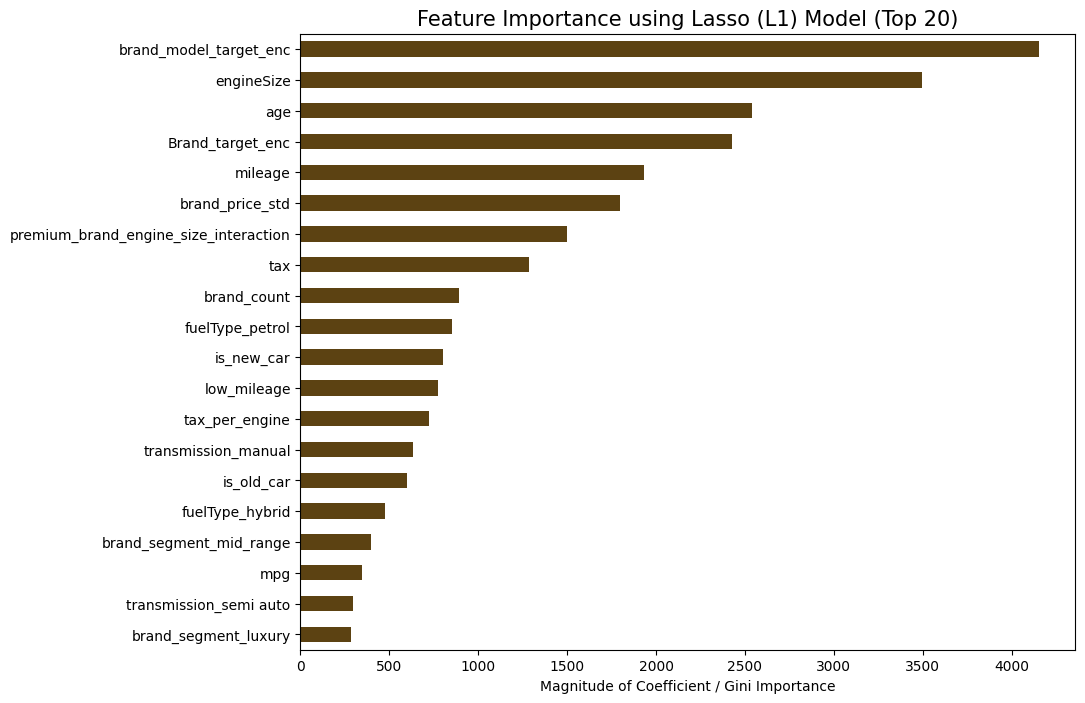

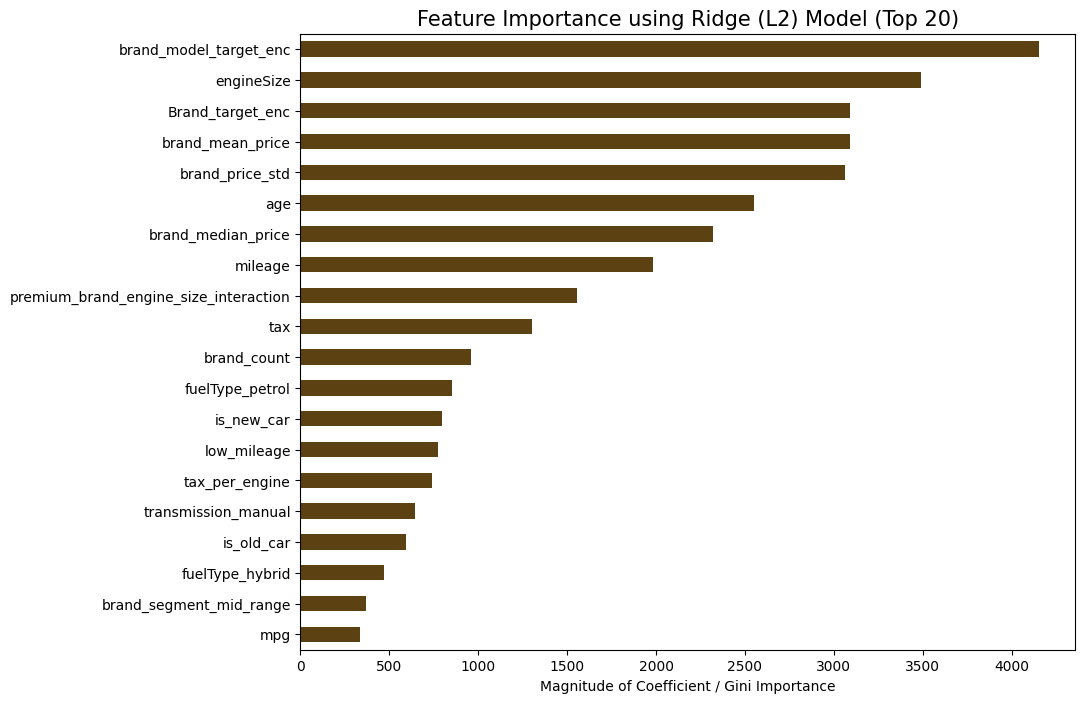

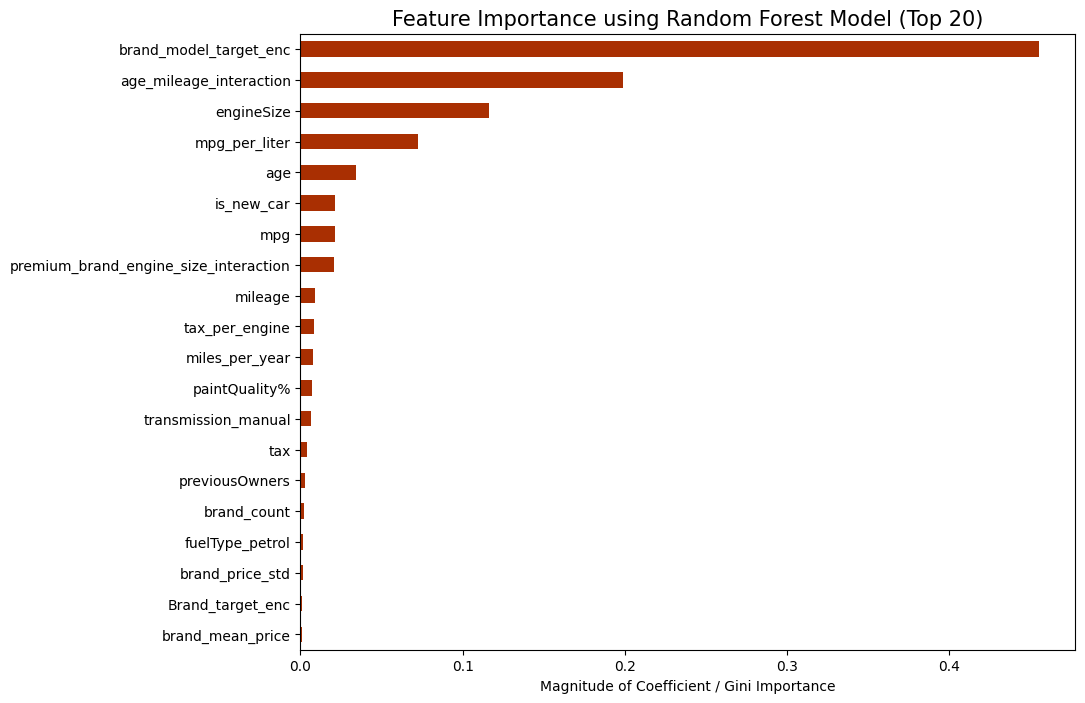

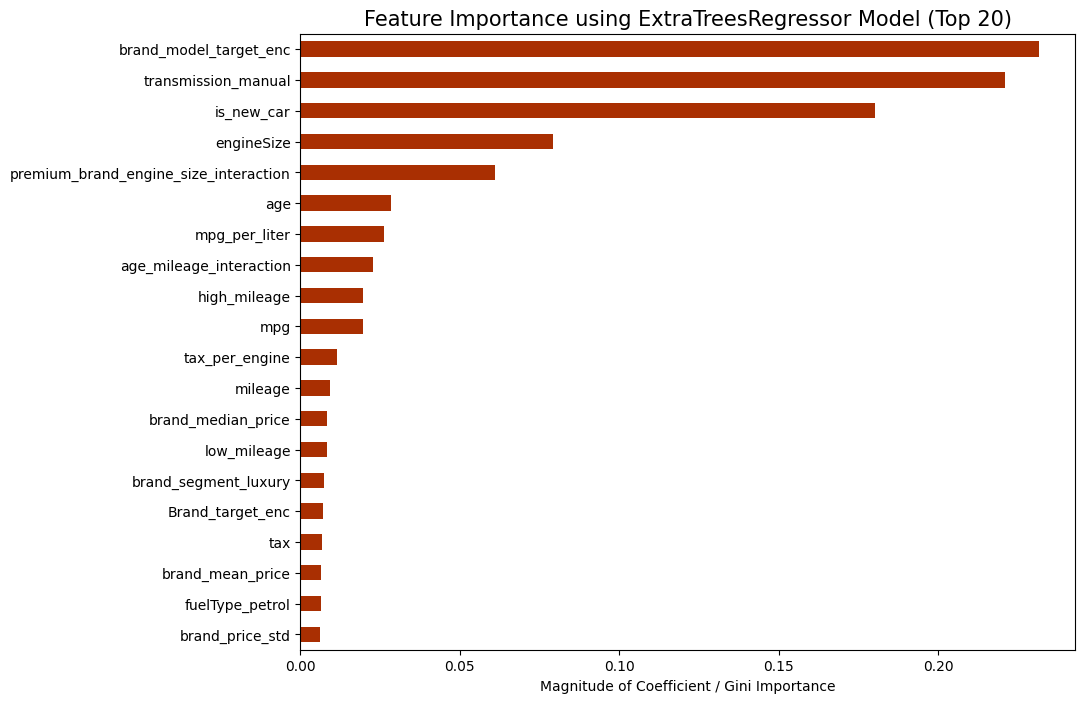

In [ ]:

# # --- Lasso Regularization (L1) ---
# lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
# lasso_model.fit(X_train, y_train)
# lasso_coefs = pd.Series(lasso_model.coef_, index=X_train.columns)
# plot_importance_unified(abs(lasso_coefs), "Lasso (L1)", is_tree_model=False) 

# # --- Ridge Regularization (L2) ---
# ridge_model = Ridge(alpha=1.0, random_state=37)
# ridge_model.fit(X_train, y_train)
# ridge_coefs = pd.Series(ridge_model.coef_, index=X_train.columns)
# plot_importance_unified(abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 

# # --- Random Forest ---
# rf_model_emb = RandomForestRegressor(n_estimators=100, random_state=37, n_jobs=-1)
# rf_model_emb.fit(X_train, y_train)
# rf_importance = pd.Series(rf_model_emb.feature_importances_, index=X_train.columns)
# plot_importance_unified(rf_importance, "Random Forest", is_tree_model=True) 

# # --- Extra Trees Regressor ---
# et_model = ExtraTreesRegressor(n_estimators=100, random_state=37, n_jobs=-1)
# et_model.fit(X_train, y_train)
# et_importance = pd.Series(et_model.feature_importances_, index=X_train.columns)
# plot_importance_unified(et_importance, "ExtraTreesRegressor", is_tree_model=True)

In [21]:
X_train.columns

Index(['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'mpg_is_missing', 'tax_is_missing',
       'engineSize_is_missing', 'year_is_missing', 'brand_mean_price',
       'brand_median_price', 'brand_price_std', 'brand_count', 'age',
       'is_new_car', 'is_old_car', 'miles_per_year', 'high_mileage',
       'low_mileage', 'age_mileage_interaction',
       'premium_brand_engine_size_interaction', 'tax_per_engine',
       'mpg_per_liter', 'Brand_target_enc', 'brand_model_target_enc',
       'transmission_manual', 'transmission_other', 'transmission_semi auto',
       'transmission_unknown', 'fuelType_electric', 'fuelType_hybrid',
       'fuelType_other', 'fuelType_petrol', 'fuelType_unknown',
       'brand_segment_luxury', 'brand_segment_mid_range'],
      dtype='object')

  
| Predictor                                 | Chi-Squared | ANOVA | RFE LR | RFE RF | Lasso | Ridge | Random Forest | Extra Trees | What to do? |
|-------------------------------------------|------------|-------|--------|--------|-------|-------|----------------|--------------|--------------|
| mileage                                   | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| tax                                       | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| mpg                                       | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| engineSize                                | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| paintQuality%                             | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| previousOwners                            | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| mpg_is_missing                            | -          | -     | -      | -      | -     | -      | -              | -            | -            |
| tax_is_missing                            | -          | -     | -      | -      | -     | -      | -              | -            | -            |
| engineSize_is_missing                     | -          | -     | -      | -      | -     | -      | -              | -            | -            |
| year_is_missing                           | -          | -     | -      | -      | -     | -      | -              | -            | -            |
| brand_mean_price                          | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_median_price                        | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_price_std                           | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_count                               | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| age                                       | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| is_new_car                                | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| is_old_car                                | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| miles_per_year                            | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| high_mileage                              | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| low_mileage                               | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| age_mileage_interaction                   | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| premium_brand_engine_size_interaction     | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| tax_per_engine                            | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| mpg_per_liter                              | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| Brand_target_enc                          | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_model_target_enc                    | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| transmission_manual                       | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| transmission_other                        | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| transmission_semi auto                    | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| transmission_unknown                      | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| fuelType_electric                         | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| fuelType_hybrid                           | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| fuelType_other                            | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| fuelType_petrol                           | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| fuelType_unknown                          | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_segment_luxury                      | -          | -     | -      | -      | -     | -     | -              | -            | -            |
| brand_segment_mid_range                   | -          | -     | -      | -      | -     | -     | -              | -            | -            |

<hr>

In [12]:
# Drop `paintQuality%`, `previousOwners`, `miles_per_year`, `transmission_semi auto`, `transmission_unknown`, `fuelType_hybrid`, `fuelType_petrol`, `fuelType_unknown`
X_train.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_val.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)
X_test.drop(columns=['paintQuality%', 'previousOwners', 'miles_per_year', 'transmission_semi auto', 'transmission_unknown', 'fuelType_hybrid', 'fuelType_petrol', 'fuelType_unknown'], inplace=True)

# <span style="color: #ffffff;">3 | Regression Benchmarking</span>

<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; 
            box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>


We are dealing with a **supervised regression problem**, as the target variable `price` is **numerical and continuous**. The goal is to train a model that learns the relationship between car characteristics (`Brand`, `model`, `mileage`, `year`, ...) and `price`, allowing it to predict the value of unseen cars.

Both **linear models** such as *Linear Regression*, *Ridge*, and *ElasticNet*, and **non-linear models** such as *KNN*, *Decision Tree*, and *SVR* can be applied to this problem. We focus on predicting the **median price** because car prices often include **outliers or extreme values** that can distort mean-based predictions. The **median is robust** to such extremes, providing more reliable predictions for typical cars.

To target the median, we use **median-based loss functions**, specifically the *Mean Absolute Error* (MAE). This choice is motivated by two factors: first, MAE is strictly consistent for the median, and second, it is the evaluation metric used in the relevant Kaggle competition, ensuring that model optimization aligns with competition scoring. Additionally, we monitor **Root Mean Squared Error (RMSE)** to assess the impact of larger errors and consider the **Pinball Loss** to explore the distribution of car prices. The Pinball Loss, also known as Quantile Loss, generalizes the MAE by allowing the model to predict conditional quantiles of the target variable. It introduces an asymmetry in the penalization of errors controlled by the quantile parameter α, which ranges from zero to one. When **α = 0.5**, the Pinball Loss is equivalent to MAE up to a constant. Beyond the median, Pinball Loss can estimate other quantiles, providing flexibility for predicting lower or upper price bounds. For instance, lower quantiles could support conservative pricing strategies to minimize risk in purchasing, while higher quantiles could indicate potential market ceilings, helping the company set competitive yet safe resale prices.

**Note**: We didn't have time to explore Pinball Loss for different quantiles, but it could be an interesting avenue for future work.


In [ ]:
# EVALUATION FUNCTION 
def evaluate_model(model, X_train, y_train, X_val, y_val):
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

# MODELS AND HYPERPARAMETER GRIDS
models_and_grids = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {} # Here we have no hyperparameters to tune
    },
    "ElasticNet": {
        "model": ElasticNet(random_state=37),
        "params": {
            'alpha': [0.1, 1.0, 10.0],   # Regularization strength
            'l1_ratio': [0.1, 0.5, 0.9]  # Mix between L1 and L2
        }
    },
    "SVR": {
        "model": SVR(),
        "params": {
            'kernel': ['rbf'],
            'C': [1, 10, 100],      # Regularization parameter
            'gamma': ['scale', 'auto'] # Kernel coefficient
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(random_state=37),
        "params": {
            'max_depth': [5, 10, None], # Max depth to control overfitting
            'min_samples_leaf': [2, 5]  # Min samples per leaf
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100],      # Number of trees
            'max_depth': [10, 20],      # Max depth of trees
            'min_samples_leaf': [2, 4, 6] # Min samples per leaf
        }
    },
    "K-Neighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [3, 5, 7],   # Number of neighbors
            'weights': ['uniform', 'distance'] # Weight function
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=37),        
        "params": {
            'learning_rate': [0.1],
            'max_depth': [3,7],
            'min_samples_leaf': [3,5],
            'n_estimators': [200],
            'subsample': [1.0, 0.8]
        }
    }
}


# MODEL TRAINING AND EVALUATION LOOP
results_list = []

# Iterate over each model defined in the dictionary
for model_name, config in models_and_grids.items():
    print(f"--- Processing model: {model_name} ---")
    param_grid = ParameterGrid(config['params'])
    best_model_results = None
    best_val_mae = float('inf')

    # Handle Linear Regression which has no grid
    if not list(param_grid):
        model = config['model']
        # Fit the model directly using X_train
        model.fit(X_train, y_train)
        scores = evaluate_model(model, X_train, y_train, X_val, y_val)
        best_model_results = {
            'Model': model_name,
            'Best Params': '{}',
            **scores
        }
    else:
        # Iterate over each combination of hyperparameters
        for params in param_grid:
            model = config['model']
            model.set_params(**params)
            
            # Fit the model directly using X_train
            model.fit(X_train, y_train)
            
            # Evaluate the model using the new evaluation function
            scores = evaluate_model(model, X_train, y_train, X_val, y_val)
            
            print(f"  Params: {params} -> Val MAE: {scores['Val MAE']:.4f}")
            
            # Store the best result based on validation MAE
            if scores['Val MAE'] < best_val_mae:
                best_val_mae = scores['Val MAE']
                best_model_results = {
                    'Model': model_name,
                    'Best Params': str(params),
                    **scores
                }
    
    results_list.append(best_model_results)
    print(f"Best validation MAE for {model_name}: {best_val_mae:.4f}\n")


# GET FINAL RESULTS
results_df = pd.DataFrame(results_list)

# Sort the results by validation MAE
results_df = results_df.sort_values(by='Val MAE', ascending=True)

# Reorder columns for better readability with the new metrics
columns_order = [
    'Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Train RMSE', 
    'Val Pinball (α=0.5)', 'Train Pinball (α=0.5)', 'Best Params'
]
results_df = results_df[columns_order]
display(results_df)

--- Processing model: Linear Regression ---
  Params: {} -> Val MAE: 3584.3732
Best validation MAE for Linear Regression: 3584.3732

--- Processing model: ElasticNet ---
  Params: {'alpha': 0.1, 'l1_ratio': 0.1} -> Val MAE: 3574.3183
  Params: {'alpha': 0.1, 'l1_ratio': 0.5} -> Val MAE: 3560.8787
  Params: {'alpha': 0.1, 'l1_ratio': 0.9} -> Val MAE: 3574.9216
  Params: {'alpha': 1.0, 'l1_ratio': 0.1} -> Val MAE: 4612.7643
  Params: {'alpha': 1.0, 'l1_ratio': 0.5} -> Val MAE: 4132.4925
  Params: {'alpha': 1.0, 'l1_ratio': 0.9} -> Val MAE: 3580.9394
  Params: {'alpha': 10.0, 'l1_ratio': 0.1} -> Val MAE: 6287.6545
  Params: {'alpha': 10.0, 'l1_ratio': 0.5} -> Val MAE: 5971.1202
  Params: {'alpha': 10.0, 'l1_ratio': 0.9} -> Val MAE: 4711.4814
Best validation MAE for ElasticNet: 3560.8787

--- Processing model: SVR ---
  Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} -> Val MAE: 5439.0040
  Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'} -> Val MAE: 5390.3855
  Params: {'C': 10, 'ga

,Model,Val MAE,Train MAE,Val RMSE,Train RMSE,Val Pinball (α=0.5),Train Pinball (α=0.5),Best Params
6,Gradient Boosting,1414.714125,1228.131137,2332.313310,1840.510040,707.357063,614.065568,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa..."
4,Random Forest,1425.652334,830.480952,2535.256951,1516.135196,712.826167,415.240476,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es..."
5,K-Neighbors,1632.203881,19.121401,2860.780896,189.414295,816.101940,9.560701,"{'n_neighbors': 7, 'weights': 'distance'}"
3,Decision Tree,1690.032022,1130.649342,2937.579784,2053.653981,845.016011,565.324671,"{'max_depth': None, 'min_samples_leaf': 5}"
2,SVR,2798.116590,2758.658422,4800.256846,4723.911399,1399.058295,1379.329211,"{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}"
1,ElasticNet,3560.878693,3491.782561,5451.197579,5323.794859,1780.439346,1745.891281,"{'alpha': 0.1, 'l1_ratio': 0.5}"
0,Linear Regression,3584.373188,3509.675604,5426.879092,5287.203839,1792.186594,1754.837802,{}


**Model Selection and Final Strategy**

Upon reviewing the model performance across our validation set, the **Support Vector Regressor (SVR)** emerged as the most robust model, achieving a Validation MAE of 2798.12 and a Training MAE of 2758.66. This was the smallest gap between these scores we achieved indicating this is the model with the least overfitting (but overfitting nonetheless), making the SVR the most reliable and generalizable model.

However, for the purpose of this Kaggle competition, where maximizing our leaderboard rank is one of the objectives, we are prioritizing the model with the best predictive performance on the validation set. In this regard, the **Gradient Boosting** model was the clear top performer, achieving a significantly lower **Validation MAE of 1414.71** (with a Training MAE of 1228.14). While this model shows a higher degree of overfitting compared to the SVR, its superior validation score makes it the strategic choice for our submission.

**Note**: To ensure a fair comparison, our methodology involved testing six distinct hyperparameter combinations for each algorithm, giving every model an equitable chance to find an optimal configuration.

We will now proceed by retraining our best Gradient Boosting model on the combined training and validation datasets. This will allow the model to learn from all available data before generating the final price predictions for the test set.


In [15]:
#Combining training and validation datasets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print(f"Final training set dimensions (X): {X_train_full.shape}")
print(f"Final training set dimensions (y): {y_train_full.shape}")

# Train the Final Model with the Best Hyperparameters
best_params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'min_samples_leaf': 3,
    'n_estimators': 200,
    'subsample': 1.0,
    'random_state': 37  # Add a random_state for reproducible results
}

# Instantiate the GradientBoostingRegressor with the best parameters
final_model = GradientBoostingRegressor(**best_params)

# Train the model on the full combined dataset
final_model.fit(X_train_full, y_train_full)

# Make Predictions on the Test Set
test_predictions = final_model.predict(X_test)

# Create and Export the Submission File
print("Creating the submission file...")
submission_df = pd.DataFrame({
    'carID': X_test.index,
    'price': test_predictions
})

# Export to a CSV file without the DataFrame index
submission_df.to_csv("./project_data/Group37_Version1.csv", index=False)
print("\nSubmission file 'Group37_Version1.csv' exported successfully!")
print("First 5 rows of the submission file:")
print(submission_df.head())

Final training set dimensions (X): (75956, 8)
Final training set dimensions (y): (75956,)
Creating the submission file...

Submission file 'Group37_Version1.csv' exported successfully!
First 5 rows of the submission file:
    carID         price
0   89856  11049.956294
1  106581  21575.734207
2   80886  12659.515303
3  100174  17039.134083
4   81376  24774.715679
